# Testing with CATBoost

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
sns.set_theme()


import sys; sys.path.append("../../")
from modules.utils import load_yaml
from modules.evaluation import pretty_classification_report, plot_confusion_matrix

# Read Data

Note: in the submission, we cannot use `test.csv`. This has no labels and it is for submission only. So we need to use validation data as the test

--> This should be OK since the data size seems large enough

In [2]:
TRAIN_CONFIG_PATH = '../../config/train_config.yaml'
DATA_PATH = '../../data/01_split/'

config = load_yaml(TRAIN_CONFIG_PATH)
LABEL_ENCODING = config['LABEL_ENCODING']

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))

../../config/train_config.yaml


## Split into train and test

As said, we will use val and test as the same 

In [3]:
train_X, train_y = train_df.loc[:,train_df.columns!='leaktype'], train_df['leaktype']
valid_X, valid_y = valid_df.loc[:,train_df.columns!='leaktype'], valid_df['leaktype']

train_y = train_y.replace(LABEL_ENCODING)
valid_y = valid_y.replace(LABEL_ENCODING)

# Same testing and validation
test_X, test_y = valid_X, valid_y

## Imbalanced learning

We should attempt something for the data imbalance: better check this out

NOTE: this simple trick seems to be working!

In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(5), y=train_y)

# Train Model

<!-- Tricks: we can use custom parameters to maximize the F1 score -->

In [5]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=20000,
    verbose=200,
    objective='MultiClass',
    # labels=labels
    eval_metric = 'TotalF1',
    custom_metric='TotalF1',
    task_type="GPU",
    # class_weights=class_weights
)

clf.fit(
    train_X, train_y,
    # cat_features=labels,
    eval_set=(valid_X, valid_y),
)

Learning rate set to 0.039596
0:	learn: 0.6259693	test: 0.6270063	best: 0.6270063 (0)	total: 17.1ms	remaining: 5m 42s
200:	learn: 0.7715344	test: 0.7586133	best: 0.7586133 (200)	total: 2.32s	remaining: 3m 48s
400:	learn: 0.8277153	test: 0.8076356	best: 0.8076356 (400)	total: 4.37s	remaining: 3m 33s
600:	learn: 0.8537361	test: 0.8282362	best: 0.8298969 (593)	total: 6.39s	remaining: 3m 26s
800:	learn: 0.8730127	test: 0.8457084	best: 0.8457084 (800)	total: 8.35s	remaining: 3m 20s
1000:	learn: 0.8885005	test: 0.8557936	best: 0.8563476 (988)	total: 10.3s	remaining: 3m 14s
1200:	learn: 0.8990173	test: 0.8646178	best: 0.8648024 (1178)	total: 12.2s	remaining: 3m 10s
1400:	learn: 0.9076774	test: 0.8697647	best: 0.8700643 (1331)	total: 14.2s	remaining: 3m 8s
1600:	learn: 0.9155874	test: 0.8750532	best: 0.8752236 (1574)	total: 16.1s	remaining: 3m 4s
1800:	learn: 0.9227451	test: 0.8814147	best: 0.8815694 (1794)	total: 18s	remaining: 3m 1s
2000:	learn: 0.9278985	test: 0.8839147	best: 0.8844215 (198

# Prediction

In [6]:
pred_y = clf.predict(test_X)

# Metrics evaluation

We need to get a few metrics right

In [7]:
encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]


F1 score : 0.862


,precision,recall,f1-score,support
0,0.945583,0.911444,0.928200,1468
1,0.916914,0.907933,0.912402,1021
2,0.995528,0.963223,0.979109,3698
3,0.620596,0.898039,0.733974,255
4,0.680115,0.848921,0.755200,278
accuracy,0.936310,0.936310,0.936310,0
macro avg,0.831747,0.905912,0.861777,6720
weighted avg,0.945398,0.936310,0.939288,6720


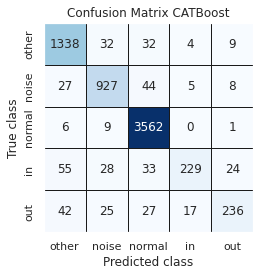

In [8]:
model_name, y_hat = 'CATBoost', pred_y

plot_confusion_matrix(test_y, y_hat, labels,  f'Confusion Matrix {model_name}')
print('F1 score : {:.3f}'.format(f1_score(test_y, y_hat, average='macro')))
pretty_classification_report(test_y, y_hat)

## Actual test for submission

In [13]:
# Setup
model = clf
LABEL_DECODING = {y:x for x,y in LABEL_ENCODING.items()}
RESULTS_PATH = '.'
DATA_DIR = '../../data/01_split'
SAMPLE_DIR = '../../data/sample_submission.csv'


test_df = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))
test_X = test_df.loc[:,test_df.columns!='id']
test_ids = test_df['id']


# Make predictions
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['id'])

y_pred = model.predict(test_X)
y_pred_df = pd.DataFrame(y_pred, columns=['leaktype'])
y_pred_df['leaktype'] = y_pred_df['leaktype'].replace(LABEL_DECODING)
pred_df = pd.concat([test_ids, y_pred_df],axis=1)

# sort predictions
resdf = pred_df.set_index('id')
result = resdf.loc[sorter].reset_index()
resultpath = os.path.join(RESULTS_PATH, 'predictions.csv')
result.to_csv(resultpath, index=False)